In [9]:
import numpy as np
from PIL import Image
import os
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [10]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).reshape(-1).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [11]:
images, labels = load_single_ring_dataset('single_ring_dataset')

In [12]:
img_size = int(np.sqrt(images[0].shape[0]))
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [16]:
def create_ring_generator(img_size):
    model = models.Sequential([
        layers.Input(shape=(5,)),  # 5 parameters: center_x, center_y, radius, thickness, deformation
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(img_size * img_size, activation='relu'),
        layers.Reshape((img_size, img_size, 1)),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
        layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')
    ])
    return model

def train_ring_generator(generator, train_images, train_labels, test_images, test_labels, img_size, epochs=20, batch_size=32):
    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss_fn = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(labels, images):
        with tf.GradientTape() as tape:
            generated_images = generator(labels, training=True)
            loss = loss_fn(images, generated_images)
        gradients = tape.gradient(loss, generator.trainable_variables)
        optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
        return loss

    X_train = train_images.reshape(-1, img_size, img_size, 1)
    X_test = test_images.reshape(-1, img_size, img_size, 1)
    
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        total_train_loss = 0
        num_batches = len(X_train) // batch_size
        for batch in range(num_batches):
            batch_labels = train_labels[batch * batch_size:(batch + 1) * batch_size]
            batch_images = X_train[batch * batch_size:(batch + 1) * batch_size]
            loss = train_step(batch_labels, batch_images)
            total_train_loss += loss

        # Compute test loss
        test_generated_images = generator.predict(test_labels)
        test_loss = loss_fn(X_test, test_generated_images)

        train_losses.append(total_train_loss / num_batches)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    
    return generator, train_losses, test_losses

def generate_ring_images(generator, labels):
    return generator.predict(labels)

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

def plot_generated_rings(generator, labels, num_samples=5, max_cols=4):
    num_samples = min(num_samples, len(labels))
    num_cols = min(num_samples, max_cols)
    num_rows = (num_samples - 1) // num_cols + 1
    figsize = (num_cols * 3, num_rows * 3)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if num_rows * num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Randomly select indices
    random_indices = np.random.choice(len(labels), num_samples, replace=False)
    selected_labels = labels[random_indices]
    
    generated_images = generate_ring_images(generator, selected_labels)
    img_size = generated_images.shape[1]
    
    for i in range(num_samples):
        ax = axes[i]
        img = generated_images[i].reshape((img_size, img_size))
        ax.imshow(img, cmap='gray')
        
        center_x, center_y, radius, thickness, deformation = selected_labels[i]
        center_x *= img_size - 1
        center_y *= img_size - 1
        radius *= img_size - 1
        
        circle = Circle((center_x, center_y), radius, fill=False, color='red')
        ax.add_patch(circle)
        
        ax.text(0.05, 1.3, f"Center: ({center_x:.1f}, {center_y:.1f})\n"
                           f"Radius: {radius:.1f}\n"
                           f"Thickness: {thickness:.2f}\n"
                           f"Deformation: {deformation:.2f}",
                transform=ax.transAxes, verticalalignment='top', color='red', fontsize=8)
        
        ax.axis('off')
    
    for i in range(num_samples, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [17]:
# Create and train the generator
generator = create_ring_generator(img_size)
trained_generator, train_losses, test_losses = train_ring_generator(generator, train_images, train_labels, test_images, test_labels, img_size, epochs=10)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Epoch 1, Train Loss: 0.1729, Test Loss: 0.1466
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 2, Train Loss: 0.1211, Test Loss: 0.0978
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 3, Train Loss: 0.0836, Test Loss: 0.0716
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 4, Train Loss: 0.0638, Test Loss: 0.0529
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 5, Train Loss: 0.0460, Test Loss: 0.0408
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 6, Train Loss: 0.0379, Test Loss: 0.0364
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 7, Train Loss: 0.0338, Test Loss: 0.0333
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 8, Train Loss: 0.0311, Test Loss: 0.0310
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Epoch 9, Train Loss: 0.0293, Test Loss: 0.0297
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 10, Train Loss: 0.0281, Test Loss: 0.0284


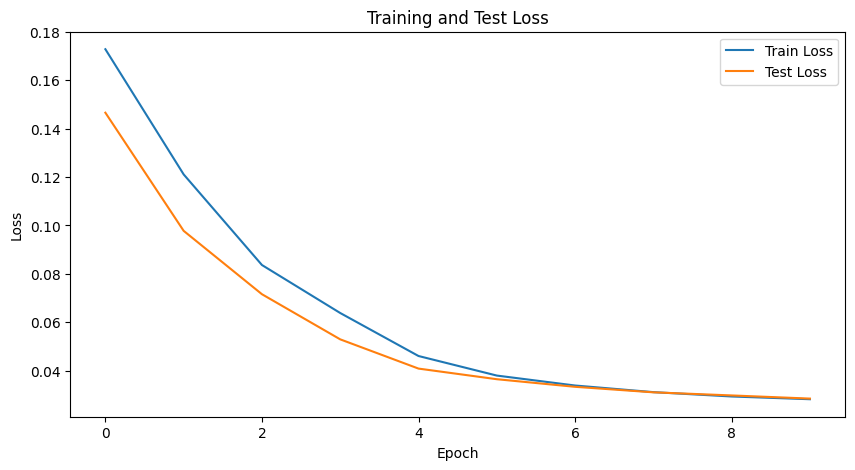

In [20]:
# Plot the losses
plot_loss(train_losses, test_losses)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


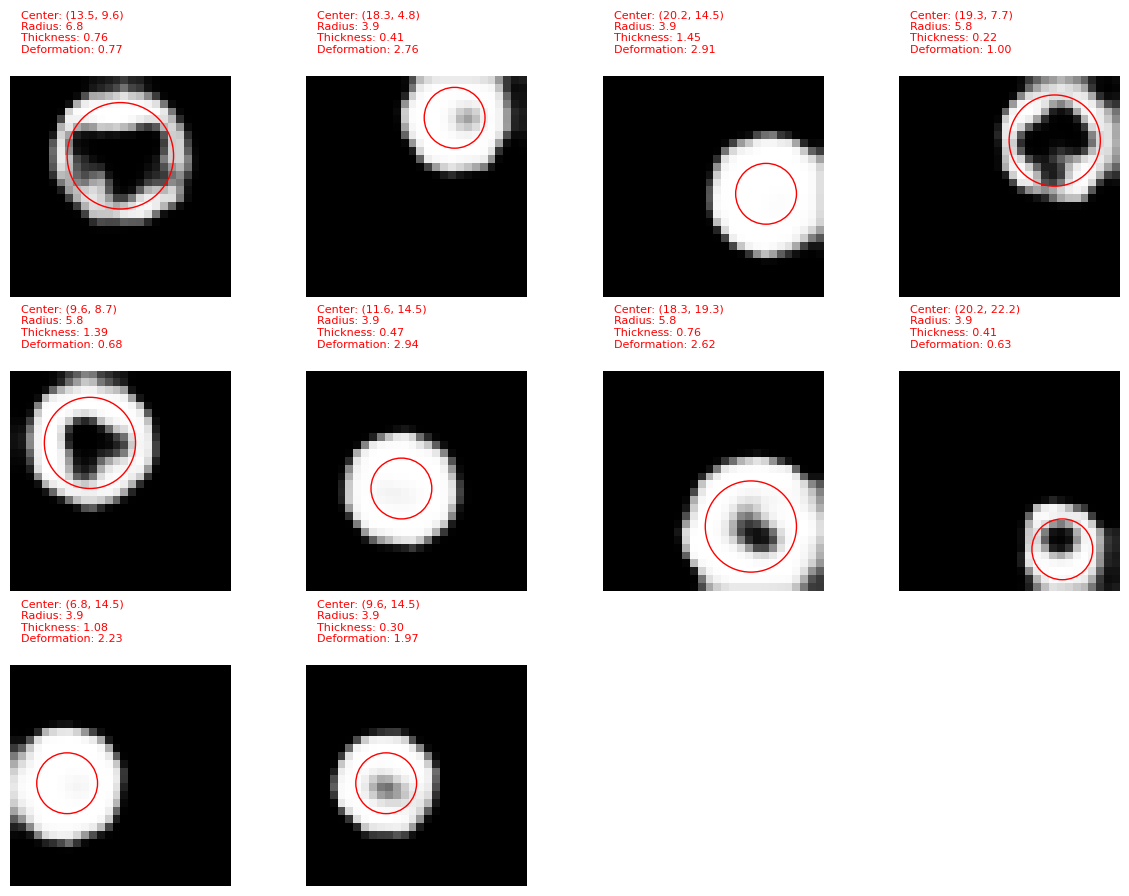

In [19]:
# Generate and plot some examples
plot_generated_rings(trained_generator, test_labels, num_samples=10)

### How does the performance of the model change with increasing & decreasing number of training examples?

### We are using a deterministic generative network but one of our parameters is not deterministic. Can you think of alternative to more closely resemble our ring examples?
HINT: Explore VAEs for this task.